## Library Imports

In [1]:
import pandas as pd
import numpy as np
import os

# for preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import re

# for building the model
import tensorflow as tf
from sklearn.model_selection import train_test_split

# for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.options.plotting.backend = "plotly"

## Exploratory Data Analysis

In [2]:
df = pd.read_csv('Suicide ideation.csv')

In [3]:
df.head(5)

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [4]:
# Check for missing data
df.isnull().sum()

Unnamed: 0    0
text          0
class         0
dtype: int64

In [5]:
# Distribution of sentiments
df['class'].value_counts()

class
suicide        116037
non-suicide    116037
Name: count, dtype: int64

In [6]:
# Digitize text attributes
df['target'] = df['class'].apply(lambda x: 1 if x == 'suicide' else 0)

# rename the first column and set it to an orders series starting at 0
df = df.rename(columns={'Unnamed: 0': 'number'})
df['number'] = range(len(df))

In [7]:
df.head(5)

,number,text,class,target
0,0,Ex Wife Threatening SuicideRecently I left my ...,suicide,1
1,1,Am I weird I don't get affected by compliments...,non-suicide,0
2,2,Finally 2020 is almost over... So I can never ...,non-suicide,0
3,3,i need helpjust help me im crying so hard,suicide,1
4,4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,1


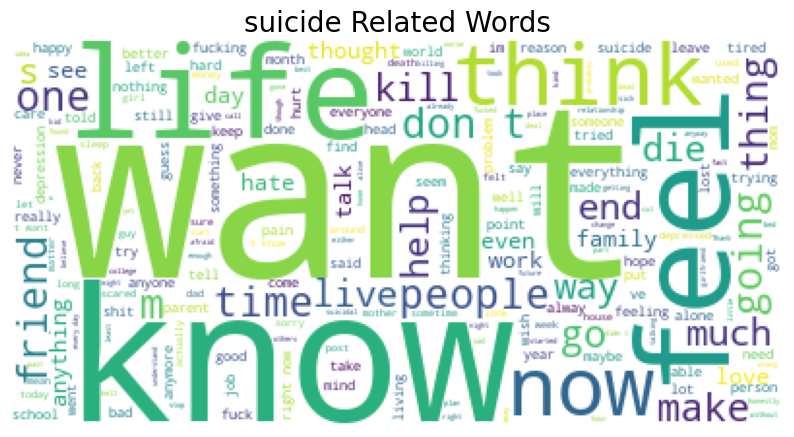

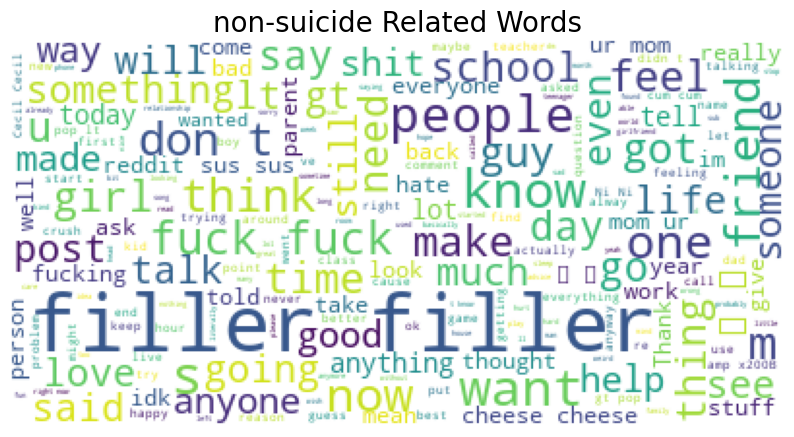

In [10]:
# visualize data into wordclouds

from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):

    # select the text in specific category
    texts = " ".join([word for word in df[df['class']==category]['text']])

    # initialize wordcloud object
    wc = WordCloud(background_color='white',
                   max_words=200,
                   stopwords=STOPWORDS)

    # generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(texts))
    plt.title('{} Related Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

# Suicide words
wordcount_gen(df, 'suicide')

# Non-Suicide words
wordcount_gen(df, 'non-suicide')

## Data Proprocessing

In [ ]:
import pickle
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
import keras.backend as K

# Data Preprocessing
def tweet_to_words(tweet):
    # convert to lowercase
    text = tweet.lower()
    # remove non letters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    # tokenize
    words = text.split()
    # remove stopwords
    words = [w for w in words if w not in stopwords.words("english")]
    # apply stemming
    words = [PorterStemmer().stem(w) for w in words]
    # return list
    return words

# Apply data processing to each tweet
X = list(map(tweet_to_words, df['text']))

# Encode target labels
y = df['target']


In [12]:
# Tokenizing & Padding
vocabulary_size = 5000
max_len = 50

# Tokenize and Pad sequences for training, validation, and testing
def tokenize_pad_sequences(text):
    '''
    This function tokenizes the input text into sequences of integers and then
    pads each sequence to the same length.
    '''
    tokenizer = Tokenizer(num_words=vocabulary_size, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X,tokenizer

print('The orginal texts before tokenize and padding \n', X[0])
X, tokenizer = tokenize_pad_sequences(X)
print('The same texts after tokenize and padding \n', X[0])


The orginal texts before tokenize and padding 
 ['ex', 'wife', 'threaten', 'suiciderec', 'left', 'wife', 'good', 'cheat', 'twice', 'lie', 'much', 'decid', 'refus', 'go', 'back', 'day', 'ago', 'began', 'threaten', 'suicid', 'tirelessli', 'spent', 'paat', 'day', 'talk', 'keep', 'hesit', 'want', 'believ', 'come', 'back', 'know', 'lot', 'peopl', 'threaten', 'order', 'get', 'way', 'happen', 'realli', 'suppos', 'handl', 'death', 'hand', 'still', 'love', 'wife', 'cannot', 'deal', 'get', 'cheat', 'constantli', 'feel', 'insecur', 'worri', 'today', 'may', 'day', 'hope', 'much', 'happen']
The same texts after tokenize and padding 
 [ 291   25  225  751    6   48   18  121  944  958   27  465   18   26
   67 2058    2  198   77   48    5  101    9  958  714    4   38   88
   17  339  479  183  330   50   32  569  406  218    4  698  309    3
 1271  268  126  272   18   98   25   88]


In [13]:
# Saving tokenized data
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


In [26]:
# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (139244, 50) (139244,)
Validation Set -> (46415, 50) (46415,)
Test Set -> (46415, 50) (46415,)


In [15]:
# Function to calculate F1 score
def f1_score(precision, recall):
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [44]:
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (139244, 5000) (139244,)
Validation Set -> (46415, 5000) (46415,)
Test Set -> (46415, 5000) (46415,)


## Model Creation: BiLSTM

In [48]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import legacy
from keras.optimizers import Adam
from keras import datasets
from keras import losses
from keras.callbacks import LearningRateScheduler, History

vocab_size = 5000
embedding_size = 32
epochs = 20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8
max_len = 50

# build the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same',activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

# compile model
optimizer = legacy.RMSprop(learning_rate=learning_rate, decay=decay_rate)
#optimizer = legacy.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(loss='binary_crossentropy', optimizer=Adam(),metrics=['accuracy', Precision(), Recall()])


In [49]:
# plot the model
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [50]:
# Print model summary
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 32)            160000    
                                                                 
 conv1d_5 (Conv1D)           (None, 50, 32)            3104      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 25, 32)            0         
 g1D)                                                            
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [51]:
# train model
batch_size = 64
history = model.fit(X_train, y_train,validation_data=(X_val, y_val),batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/20
2176/2176 [==============================] - 26s 11ms/step - loss: 0.2203 - accuracy: 0.9151 - precision_4: 0.9148 - recall_4: 0.9152 - val_loss: 0.1899 - val_accuracy: 0.9278 - val_precision_4: 0.9246 - val_recall_4: 0.9320
Epoch 2/20
2176/2176 [==============================] - 24s 11ms/step - loss: 0.1769 - accuracy: 0.9334 - precision_4: 0.9301 - recall_4: 0.9370 - val_loss: 0.1862 - val_accuracy: 0.9291 - val_precision_4: 0.9282 - val_recall_4: 0.9307
Epoch 3/20
2176/2176 [==============================] - 24s 11ms/step - loss: 0.1583 - accuracy: 0.9414 - precision_4: 0.9376 - recall_4: 0.9455 - val_loss: 0.1890 - val_accuracy: 0.9286 - val_precision_4: 0.9198 - val_recall_4: 0.9397
Epoch 4/20
2176/2176 [==============================] - 24s 11ms/step - loss: 0.1398 - accuracy: 0.9496 - precision_4: 0.9449 - recall_4: 0.9548 - val_loss: 0.2179 - val_accuracy: 0.9211 - val_precision_4: 0.9492 - val_recall_4: 0.8905
Epoch 5/20
2176/2176 [==============================] - 

### Model validation

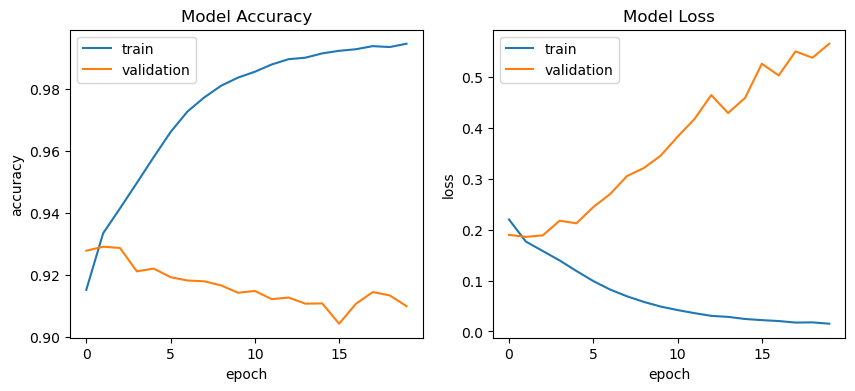

In [52]:
# define the function for plot history for accuracy and loss
def plot_training_hist(history):

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train','validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train','validation'], loc='best')

plot_training_hist(history)

In [53]:
# evaluate model on the testset
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# print metrics
print('')
print('Accuracy     :{:.4f}'.format(accuracy))
print('Precision    :{:.4f}'.format(precision))
print('Recall       :{:.4f}'.format(recall))
print('F1 Score     :{:.4f}'.format(f1_score(precision, recall)))


Accuracy     :0.9100
Precision    :0.9022
Recall       :0.9199
F1 Score     :0.9110


### Confusion Matrix

1451/1451 [==============================] - 4s 3ms/step


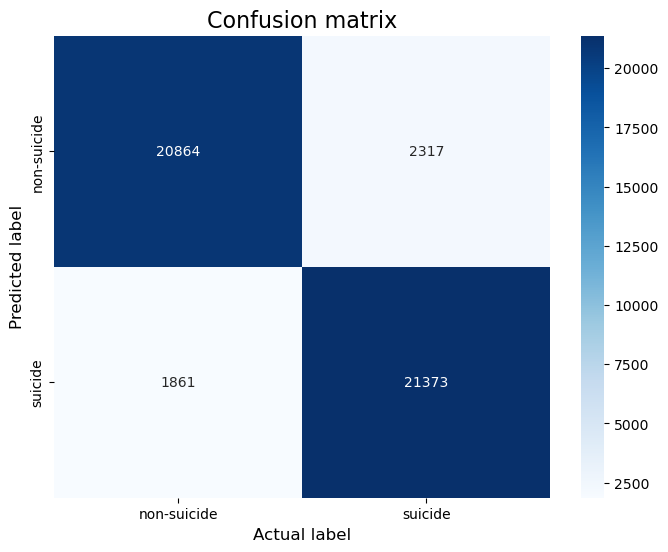

In [70]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test, threshold=0.5):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['non-suicide', 'suicide']
    # use model to do the prediction
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > threshold).astype(int)
    # compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

### Save the best model and prediction for specific texts

In [71]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


d:\anaconda3\envs\data_analytics\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [89]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Non Suicidal', 'Suicidal']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt_prob = model.predict(xt)
    yt = (yt_prob > 0.5).astype(int)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0][0]])

In [90]:
predict_class(['Despite the setbacks, I remain optimistic that things will improve, and good times are just around the corner'])

1/1 [==============================] - 0s 433ms/step
The predicted sentiment is Non Suicidal


In [91]:
predict_class(['Why is God so unfair to me! I have no one to love in this world, no one wants to love me, and I dont see hope for my future life!'])

1/1 [==============================] - 0s 15ms/step
The predicted sentiment is Suicidal


In [92]:
predict_class(['Scientists have discovered a strange, never-before-seen creature in the deep ocean that looks and behaves unlike anything known on Earth, according to new reports.'])

1/1 [==============================] - 0s 16ms/step
The predicted sentiment is Non Suicidal


In [95]:
predict_class(['just discovered a hidden gem in my neighborhood—a cozy café with the best coffee and pastries!'])

1/1 [==============================] - 0s 16ms/step
The predicted sentiment is Non Suicidal
